In [ ]:
import os
import tensorflow as tf
import numpy as np
import shutil
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image

## **PREPARING DATASET**

In [ ]:
# Define the path to the dataset and the categories
dataset_dir = 'Image_classification Dataset'
categories = ['dark circle', 'acne', 'wrinkle', 'normal']

# Define the target size for resizing
img_height, img_width = 224, 224

## **MAKE FOLDER FOR DATASET**

In [ ]:
# Destination folders for training and validation
TRAIN_DIR = 'data/train/'
VALIDATION_DIR = 'data/validation/'
split_ratio = 0.8 

# Create train and validation folders if they don't exist
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VALIDATION_DIR, exist_ok=True)

## **PRE-PROCESSING**

In [ ]:
def load_and_preprocess_data(directory, img_height=224, img_width=224):
    images = []
    labels = []
    class_counts = {}

    # Get sorted list of class names and assign numeric labels
    class_names = sorted(os.listdir(directory))  
    class_labels = {class_name: idx for idx, class_name in enumerate(class_names)}

    # Iterate through each class folder
    for class_name, label in class_labels.items():
        class_folder = os.path.join(directory, class_name)
        class_counts[class_name] = 0

        # Process each image in the class folder
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                # Open the image, convert to RGB, and resize
                image = Image.open(file_path).convert("RGB")
                image = image.resize((img_width, img_height))

                # Normalize pixel values to the range [0, 1]
                image_array = np.array(image, dtype=np.float32) / 255.0

                # Append the processed image and label to respective lists
                images.append(image_array)
                labels.append(label)

                # Update the count of images for the class
                class_counts[class_name] += 1
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    # Convert labels to one-hot encoding
    num_classes = len(class_names)
    labels_one_hot = np.eye(num_classes)[labels]  

    # Display preprocessing summary
    print("Preprocessing completed:")
    for class_name, count in class_counts.items():
        print(f" - {class_name}: {count} images")

    # Return preprocessed data and class metadata    
    return np.array(images), labels_one_hot, class_labels, class_counts

# Call the function to preprocess the data
images, labels_one_hot, class_labels, class_counts = load_and_preprocess_data(dataset_dir)

# Get the total number of images and their shapes
total_images = len(images)
shape_images = images.shape
shape_labels = labels_one_hot.shape


Preprocessing completed:
 - Acne: 300 images
 - Dark Circle: 302 images
 - Normal: 316 images
 - Wrinkle: 300 images


## **SPLIT DATASET**

In [ ]:
def split_dataset(directory, train_dir, val_dir, split_ratio=0.8):
    class_labels = { 'acne': 0, 'dark circle': 1, 'normal': 2, 'wrinkle': 3 }
    
    # Use the specified directories for training and validation
    for class_name, label in class_labels.items():
        class_folder = os.path.join(directory, class_name)
        train_folder = os.path.join(train_dir, class_name)
        val_folder = os.path.join(val_dir, class_name)

        # Create folders for each category in training and validation if they don't exist
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)

        # Retrieve image file names from the class folder
        image_files = [img for img in os.listdir(class_folder) if img.endswith(('jpg', 'png', 'jpeg'))]
        
        # Split the data into training and validation sets
        train_files, val_files = train_test_split(image_files, test_size=1 - split_ratio)

        # Copy files to the training folder
        for file_name in train_files:
            src = os.path.join(class_folder, file_name)
            dst = os.path.join(train_folder, file_name)
            shutil.copy(src, dst)

        for file_name in val_files:
            src = os.path.join(class_folder, file_name)
            dst = os.path.join(val_folder, file_name)
            shutil.copy(src, dst)

        print(f"Class '{class_name}': {len(train_files)} training images, {len(val_files)} validation images.")

# Ensure the dataset directory paths are correct
dataset_dir = 'Image_classification Dataset'  
TRAIN_DIR = 'data/train/' 
VALIDATION_DIR = 'data/validation/' 

# Call the function to process the dataset
split_dataset(dataset_dir, TRAIN_DIR, VALIDATION_DIR)

print("Dataset split completed!")


Class 'acne': 240 training images, 60 validation images.
Class 'dark circle': 241 training images, 61 validation images.
Class 'normal': 252 training images, 64 validation images.
Class 'wrinkle': 240 training images, 60 validation images.
Dataset split completed!


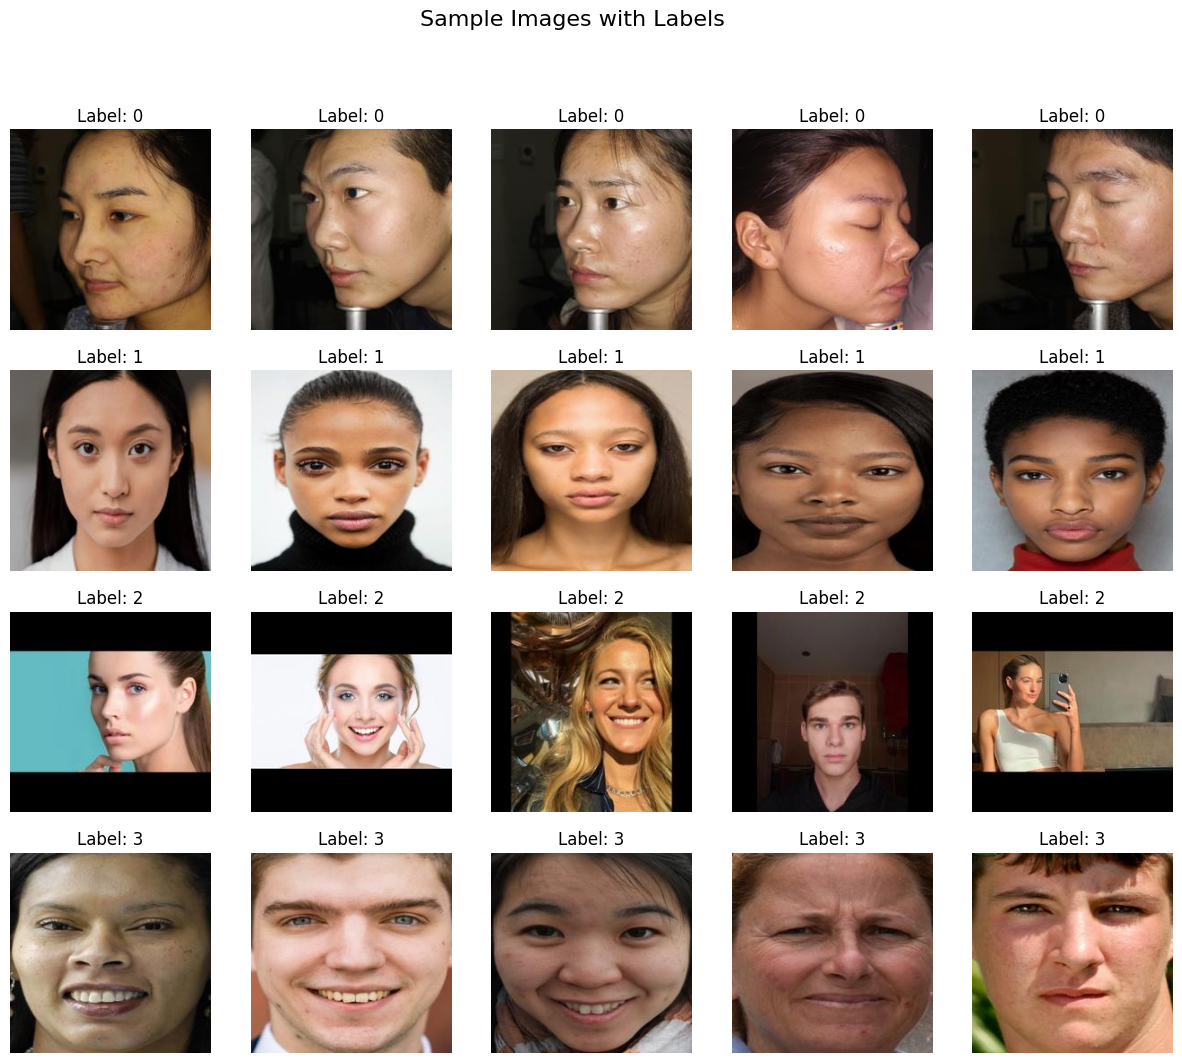

In [ ]:
# Path to the processed dataset
train_dir = 'data/train'

# Automatically generate category list based on subdirectories in the train folder
categories = sorted(os.listdir(train_dir))

# Create lists to store images and their labels
images = []
labels = []

# Loop through each category to load images and assign labels
for label, category in enumerate(categories):
    category_dir = os.path.join(train_dir, category)
    
    # Select the first 5 images from the category folder
    for img_name in os.listdir(category_dir)[:5]:
        img_path = os.path.join(category_dir, img_name)
        
        # Load the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Resize gambar
        
        # Add the image and its label to the lists
        images.append(img)
        labels.append(label)

# Define the number of images to display
num_images = len(images)

# Define the number of columns (e.g., 5 images per row)
cols = 5
rows = (num_images + cols - 1) // cols

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
fig.suptitle('Sample Images with Labels', fontsize=16)

# Loop to display images
for i, ax in enumerate(axes.flat): 
    if i < num_images:  
        ax.imshow(images[i])
        ax.set_title(f'Label: {labels[i]}')
    ax.axis('off') 

# Show the plot
plt.show()


## **AUGMENTATION DATA**

In [ ]:
# Prepare the augmentation generator for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)

# Prepare the generator for validation data
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [ ]:
# Define new directories
TRAIN_DIR = 'data/train'
VALIDATION_DIR = 'data/validation'

# Image dimensions
img_height, img_width = 224, 224  

# Load image data from the train and validation directories using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,  
    target_size=(img_height, img_width),  
    batch_size=64, 
    class_mode='categorical'  
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,  
    target_size=(img_height, img_width),  
    batch_size=64,  
    class_mode='categorical'  
)



Found 973 images belonging to 4 classes.
Found 245 images belonging to 4 classes.


## **BUILD MODEL**

In [ ]:
# Define the number of classes
num_classes = len(categories)

# Load the pre-trained VGG16 model without the fully connected layer (top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the weights of the pre-trained model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,  
    GlobalAveragePooling2D(),  
    Dense(512, activation='relu'),  
    Dense(num_classes, activation='softmax') 
])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

## **CHECKING MODEL COMPATIBILITY**

In [11]:
# Fetch example batch (images and labels) from the train generator
example_batch_images, example_batch_labels = next(train_generator)

# Check if the model is compatible with the dataset
try:
    model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except Exception as e:
    print("Your model is not compatible with the dataset you defined earlier. "
          "Check that the loss function, last layer and label_mode are compatible with one another.")
    print(f"Error details: {e}")
else:
    predictions = model.predict(example_batch_images, verbose=False)
    print(f"predictions have shape: {predictions.shape}")

predictions have shape: (64, 4)


## **TRAINING MODEL**

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,  
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

c:\Users\YURISTA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.2326 - loss: 1.4559 - val_accuracy: 0.2163 - val_loss: 1.4214
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.2587 - loss: 1.4238 - val_accuracy: 0.2408 - val_loss: 1.3975
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.2567 - loss: 1.4090 - val_accuracy: 0.2490 - val_loss: 1.3782
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.2889 - loss: 1.3921 - val_accuracy: 0.2980 - val_loss: 1.3618
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.3257 - loss: 1.3741 - val_accuracy: 0.3429 - val_loss: 1.3477
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.3312 - loss: 1.3639 - val_accuracy: 0.3633 - val_loss: 1.3357
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.3796 - loss: 1.3437 - val_accuracy: 0.3796 - val_loss: 1.3254
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - accuracy: 0.3776 - loss: 1.3353 - val_accuracy: 0.4041 - val_loss

## **FINE TUNING**

In [ ]:
# Unlock layers from the pre-trained model for fine-tuning
base_model.trainable = True

# Freeze all layers except for the last few layers
fine_tune_at = 10 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, 
                    epochs=15, 
                    validation_data=validation_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.7461 - loss: 0.9623 - val_accuracy: 0.8122 - val_loss: 0.6095
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 0.7967 - loss: 0.6405 - val_accuracy: 0.8163 - val_loss: 0.4136
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.8254 - loss: 0.4736 - val_accuracy: 0.8653 - val_loss: 0.3437
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.8747 - loss: 0.3693 - val_accuracy: 0.8531 - val_loss: 0.3452
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 253s 16s/step - accuracy: 0.8767 - loss: 0.3159 - val_accuracy: 0.9061 - val_loss: 0.2540
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.9006 - loss: 0.2987 - val_accuracy: 0.8694 - val_loss: 0.2823
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.8923 - loss: 0.2661 - val_accuracy: 0.9143 - val_loss: 0.2083
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.9175 - loss: 0.2363 - val_accuracy: 0.9265 - 

## **EVALUATE ON THE MODEL**

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator)  
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9626 - loss: 0.1318
Test accuracy: 94.69%
Test loss: 14.45%


## **PLOTTING TRAINING AND VALIDATION ACCURACY AND LOSS**

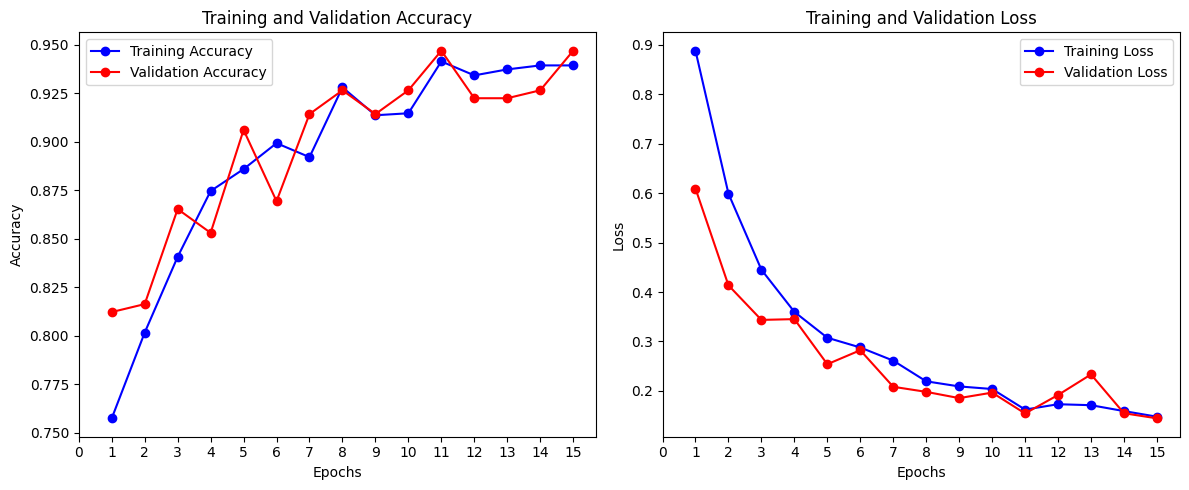

In [ ]:
# Extract training and validation data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the number of epochs
epochs = range(1, len(acc) + 1)

# Create a plot for accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(0, len(epochs) + 1))  

# Create a plot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(0, len(epochs) + 1)) 

plt.tight_layout()
plt.show()


## **CONFUSION MATRIX**

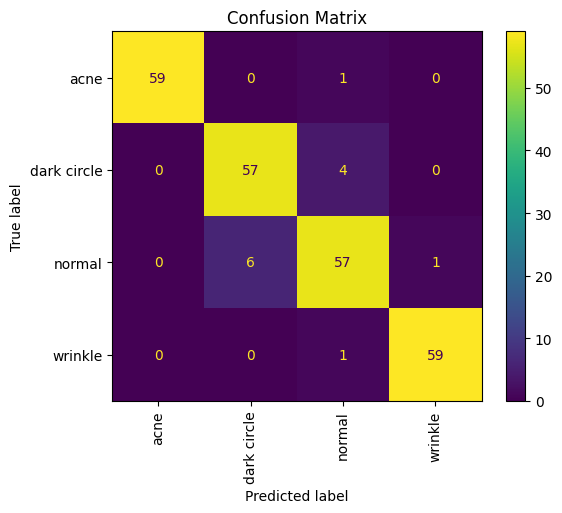

In [ ]:
# Get the true labels and predictions from validation_generator
y_true = []
y_pred = []

# Loop through the validation_generator
for batch_images, batch_labels in validation_generator:
    # Predict the batch
    predictions = model.predict(batch_images, verbose=0)
    
    # Add the true labels (using argmax for multiclass)
    y_true.extend(np.argmax(batch_labels, axis=1))  
    
    # Add the model predictions (using argmax for multiclass)
    y_pred.extend(np.argmax(predictions, axis=1))  
    
    # Stop after all data is processed
    if len(y_true) >= validation_generator.samples:
        break

# Reverse the mapping from class_indices to get the class names
classes = {v: k for k, v in validation_generator.class_indices.items()}

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()


## **CLASSIFICATION REPORT**

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.90      0.93      0.92        61
           2       0.90      0.89      0.90        64
           3       0.98      0.98      0.98        60

    accuracy                           0.95       245
   macro avg       0.95      0.95      0.95       245
weighted avg       0.95      0.95      0.95       245



## **TESTING THE MODEL WITH A NEW IMAGE**

In [ ]:
# Load and process the image
img_path = 'dark circle 4.png'  # Ganti dengan path gambar baru
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0  # Normalisasi
img_array = np.expand_dims(img_array, axis=0)  # Menambah dimensi batch

# Prediction
prediction = model.predict(img_array)  # Hasil berupa probabilitas untuk setiap kelas

# Convert to percentages
prediction_percentages = prediction[0] * 100  # Ambil batch pertama, lalu konversi ke persentase

# Define class names
categories = {0: 'acne', 1: 'dark circle', 2: 'normal', 3: 'wrinkle'}

# Display the prediction results for each class
for idx, prob in enumerate(prediction_percentages):
    print(f"{categories[idx]}: {prob:.2f}%")

# Determine the class with the highest probability
predicted_class = np.argmax(prediction) 
print(f"Predicted class: {categories[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
acne: 0.00%
dark circle: 67.13%
normal: 32.36%
wrinkle: 0.50%
Predicted class: dark circle


## **SAVE THE MODEL**

In [35]:
model.save('model_transfer_learning_VGG16.h5')